# 0.Preflight

In [2]:
# =========================================================
# 0) Preflight: 환경/버전/시드/백엔드 + 공통 유틸
# =========================================================
import os, sys, warnings, random
import numpy as np, pandas as pd
warnings.filterwarnings("ignore")

# 노트북 플롯
try: get_ipython().run_line_magic("matplotlib", "inline")
except Exception: pass
import matplotlib as mpl, matplotlib.pyplot as plt
plt.ioff(); mpl.rcParams["figure.dpi"]=140; mpl.rcParams["axes.unicode_minus"]=False

# torch가 있으면 시드, 없으면 생략
try:
    import torch
    def reset_seeds(seed=42):
        random.seed(seed); os.environ['PYTHONHASHSEED']=str(seed)
        np.random.seed(seed); torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic=True
        torch.backends.cudnn.benchmark=False
except Exception:
    def reset_seeds(seed=42):
        random.seed(seed); os.environ['PYTHONHASHSEED']=str(seed); np.random.seed(seed)

reset_seeds(42)

# 전역 가드/정합 유틸
def assert_split_ok(X_tr, y_tr, X_te, y_te):
    assert len(X_tr)==len(y_tr), f"Train length mismatch: X={len(X_tr)}, y={len(y_tr)}"
    assert len(X_te)==len(y_te), f"Holdout length mismatch: X={len(X_te)}, y={len(y_te)}"
    print(f"[OK] split lens: tr={len(X_tr)} te={len(X_te)}")

def align_columns_pair(X_train: pd.DataFrame, X_test: pd.DataFrame):
    tr_cols=set(X_train.columns); te_cols=set(X_test.columns)
    for c in (tr_cols - te_cols): X_test[c]=pd.NA
    for c in (te_cols - tr_cols): X_train[c]=pd.NA
    X_train=X_train.reindex(sorted(X_train.columns), axis=1)
    X_test =X_test.reindex(X_train.columns, axis=1)
    return X_train, X_test

def clear_old_derivatives():
    for k in list(globals().keys()):
        if k.endswith(('_d','_final')) or k in ('groups_tr','groups_te','fare_bins','ticket_counts'):
            try: del globals()[k]
            except: pass


# 1. 데이터 로드

In [3]:
# =========================================================
# 1) 경로/데이터 로드
# =========================================================
BASE_PATH = os.getcwd()
DATA_PATH = os.path.join(BASE_PATH, "data")
SUB_PATH  = os.path.join(BASE_PATH, "submissions")
os.makedirs(SUB_PATH, exist_ok=True)

train_csv = os.path.join(DATA_PATH, "train.csv")
test_csv  = os.path.join(DATA_PATH, "test.csv")

ori_train = pd.read_csv(train_csv)
ori_test  = pd.read_csv(test_csv)

print("Train:", ori_train.shape, "Test:", ori_test.shape)


Train: (916, 12) Test: (393, 11)


# 2. Split

In [4]:
# =========================================================
# 2) Split (strat/group 중 택1) + 인덱스 리셋
# =========================================================
from sklearn.model_selection import train_test_split, GroupShuffleSplit

MODE_SPLIT = "strat"  # "strat" 또는 "group"
RANDOM_STATE = 42

y = ori_train['survived'].astype(int)
X = ori_train.drop(columns=['survived'])

def make_groups_from_name(df: pd.DataFrame):
    return df['name'].astype(str).str.split(",").str[0].str.strip()

clear_old_derivatives()

if MODE_SPLIT=="group":
    groups_all = make_groups_from_name(ori_train)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=RANDOM_STATE)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups_all))
    X_tr = X.iloc[tr_idx].reset_index(drop=True)
    X_te = X.iloc[te_idx].reset_index(drop=True)
    y_tr = y.iloc[tr_idx].reset_index(drop=True)
    y_te = y.iloc[te_idx].reset_index(drop=True)
    groups_tr = groups_all.iloc[tr_idx].reset_index(drop=True)
    groups_te = groups_all.iloc[te_idx].reset_index(drop=True)
else:
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
    )
    X_tr = X_tr.reset_index(drop=True); X_te = X_te.reset_index(drop=True)
    y_tr = y_tr.reset_index(drop=True); y_te = y_te.reset_index(drop=True)
    groups_tr = None; groups_te = None

assert_split_ok(X_tr, y_tr, X_te, y_te)


[OK] split lens: tr=641 te=275


# 3. 결측치

In [5]:
# =========================================================
# 3) 결측치 채움 (Train 기준)
# =========================================================
def compute_train_fillers(X_tr: pd.DataFrame) -> dict:
    fillers = {}
    fillers['age_by_pclass'] = X_tr.groupby('pclass')['age'].median()
    fillers['fare_median']   = X_tr['fare'].median()
    fillers['embarked_mode'] = X_tr['embarked'].mode()[0]
    return fillers

def apply_fillers(df: pd.DataFrame, fillers: dict) -> pd.DataFrame:
    out = df.copy()
    out['age'] = out['age'].fillna(out['pclass'].map(fillers['age_by_pclass']))
    out['fare'] = out['fare'].fillna(fillers['fare_median'])
    out['embarked'] = out['embarked'].fillna(fillers['embarked_mode'])
    return out


# 4. Feature Engineering

In [6]:
# =========================================================
# 4) Feature Engineering (기본 + 확장)
# =========================================================
def fam_categorized(size):
    if size == 1: return "S"
    if size >= 5: return "L"
    return "M"

def _age_bin(age):
    if pd.isna(age): return np.nan
    if age <= 12: return "child"
    if age <= 18: return "teen"
    if age <= 60: return "adult"
    return "elderly"

def _fare_bin(fare):
    if pd.isna(fare): return np.nan
    if fare < 10: return "low"
    if fare < 30: return "mid"
    return "high"


def add_basic_fe(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['deck'] = out['cabin'].apply(lambda x: "Y" if pd.notna(x) else "N")
    out['name_length'] = out['name'].astype(str).str.len()
    out['fam_size'] = out['sibsp'] + out['parch'] + 1
    out['fam_category'] = out['fam_size'].map(fam_categorized)
    out['fare_per_head'] = out['fare'] / out['fam_size'].replace(0, 1)
    out['age_bin']  = out['age'].apply(_age_bin)
    out['fare_bin'] = out['fare'].apply(_fare_bin)
    out['is_child']   = (out['age'] <= 12).astype('Int32')
    out['is_elderly'] = (out['age'] >= 60).astype('Int32')
    out['is_female']  = (out['gender'] == 'female').astype('Int32')
    out['is_male']    = (out['gender'] == 'male').astype('Int32')
    out['female_child']   = ((out['gender']=='female') & (out['age']<=12)).astype('Int32')
    out['female_elderly'] = ((out['gender']=='female') & (out['age']>=60)).astype('Int32')
    out['male_child']     = ((out['gender']=='male')   & (out['age']<=12)).astype('Int32')
    out['male_elderly']   = ((out['gender']=='male')   & (out['age']>=60)).astype('Int32')
    for g in ['female','male']:
        for pc in [1,2,3]:
            out[f'{g}_pclass{pc}'] = ((out['gender']==g) & (out['pclass']==pc)).astype('Int32')
    out['sex_agebin']  = out['gender'].astype(str) + "_" + out['age_bin'].fillna('unknown').astype(str)
    out['sex_farebin'] = out['gender'].astype(str) + "_" + out['fare_bin'].fillna('unknown').astype(str)
    for col in ['fare','fare_per_head','name_length']:
        v = pd.to_numeric(out[col], errors='coerce').clip(lower=0)
        out[f"{col}_log1p"] = np.log1p(v)
    out['is_alone'] = (out['fam_size']==1).astype('Int32')
    return out

import re
def extract_title(name: str):
    if pd.isna(name): return "Unknown"
    m = re.search(r",\s*([^\.]+)\.", str(name))
    t = m.group(1).strip() if m else "Unknown"
    mapping = {"Mlle":"Miss","Ms":"Miss","Mme":"Mrs",
               "Lady":"Rare","Countess":"Rare","Sir":"Rare","Jonkheer":"Rare","Dona":"Rare",
               "Capt":"Rare","Col":"Rare","Major":"Rare","Dr":"Rare","Rev":"Rare"}
    return mapping.get(t, t)

def add_strong_fe(df: pd.DataFrame, ticket_counts: pd.Series=None, fare_bins=None,
                  fare_bin_labels=("low","mid","high")) -> pd.DataFrame:
    out = df.copy()
    out["title"] = out["name"].apply(extract_title)
    out["title"] = out["title"].apply(lambda x: x if x in {"Master","Miss","Mrs","Mr"} else "Rare")
    out["is_mother"] = ((out["gender"]=="female") & (out["age"]>=18) & (out["parch"]>0)).astype("Int32")
    out["ticket_str"]  = out["ticket"].astype(str)
    out["deck_letter"] = out["cabin"].astype(str).str[0].where(out["cabin"].notna(), "M")
    out["surname"] = out["name"].astype(str).str.split(",").str[0].str.strip()
    mapping = {"A":"ABC","B":"ABC","C":"ABC","D":"DEF","E":"DEF","F":"DEF","G":"G","M":"M"}
    out["deck_group"] = out["deck_letter"].map(mapping).fillna("M")
    if ticket_counts is not None:
        out["ticket_group_size"] = out["ticket_str"].map(ticket_counts).fillna(1).astype(int)
        out["ticket_group_size_log1p"] = np.log1p(out["ticket_group_size"])
    if fare_bins is not None:
        out["fare_qcut"] = pd.cut(out["fare"], bins=fare_bins,
                                  labels=fare_bin_labels, include_lowest=True, duplicates="drop")
        out["sex_fare_qcut"] = out["gender"].astype(str) + "_" + out["fare_qcut"].astype(str)
    out["fare_div_pclass"] = out["fare"] / out["pclass"]
    out["age_x_pclass"] = out["age"] * out["pclass"]
    if "fare_per_head" in out.columns:
        out["fare_per_head_div_pclass"] = out["fare_per_head"] / out["pclass"]
    return out

def add_error_slice_fe(df: pd.DataFrame, ticket_counts: pd.Series=None) -> pd.DataFrame:
    """
    분석에서 드러난 오류 구간(어린 남자아이, Master, 30~40대 성인, 무임승차, 남자+고운임, 여자+pclass3,
    가족규모 x 성별/칭호 상호작용, 티켓/데크 보조정보)을 직접 캡처하는 파생 피처들.
    - add_basic_fe, add_strong_fe 이후 호출 권장
    """
    out = df.copy()

    # ----- 안전 가드: 필요한 컬럼 없으면 최소 생성 -----
    if "title" not in out.columns:
        out["title"] = out["name"].apply(extract_title).apply(
            lambda x: x if x in {"Master","Miss","Mrs","Mr"} else "Rare"
        )
    if "fam_size" not in out.columns:
        out["fam_size"] = out["sibsp"] + out["parch"] + 1
    if "fare_qcut" not in out.columns:
        try:
            out["fare_qcut"] = pd.qcut(out["fare"], q=3, labels=["low","mid","high"])
        except ValueError:
            out["fare_qcut"] = pd.cut(out["fare"], bins=[-1,10,30,out["fare"].max()],
                                      labels=["low","mid","high"])

    # ===== 1) 어린 남자아이 / Master 관련 =====
    out["is_child_male"] = ((out["gender"]=="male") & (out["age"]<=12)).astype("Int32")
    out["is_master"]     = (out["title"]=="Master").astype("Int32")
    # 보강: 어린이이면서 3등석 여부
    out["child_pclass3"] = ((out["age"]<=12) & (out["pclass"]==3)).astype("Int32")

    # ===== 2) 남자 + 고운임 (오류 다수) =====
    out["male_highfare"] = ((out["gender"]=="male") & (out["fare_qcut"]=="high")).astype("Int32")
    # 세밀화: 남자 + high fare + 1,2등석
    out["male_highfare_hi_class"] = ((out["gender"]=="male") &
                                     (out["fare_qcut"]=="high") &
                                     (out["pclass"].isin([1,2]))).astype("Int32")

    # ===== 3) 나이 30~44, 45~54 구간 =====
    out["age_30_34"] = ((out["age"]>=30) & (out["age"]<=34)).astype("Int32")
    out["age_35_44"] = ((out["age"]>=35) & (out["age"]<=44)).astype("Int32")
    out["age_45_54"] = ((out["age"]>=45) & (out["age"]<=54)).astype("Int32")
    # 성별 상호작용(중년 남성/여성 구분)
    out["male_35_44"]   = ((out["gender"]=="male") & out["age_35_44"].astype(bool)).astype("Int32")
    out["female_35_44"] = ((out["gender"]=="female") & out["age_35_44"].astype(bool)).astype("Int32")

    # ===== 4) 무임승차(요금=0) =====
    out["fare_zero"] = (out["fare"].fillna(0)==0).astype("Int32")
    # 보강: 무임 + 3등석 / 무임 + 남성
    out["fare_zero_pclass3"] = (out["fare_zero"].astype(bool) & (out["pclass"]==3)).astype("Int32")
    out["fare_zero_male"]    = (out["fare_zero"].astype(bool) & (out["gender"]=="male")).astype("Int32")

    # ===== 5) 이름 길이 30~40은 title로 대체하되, 드문 칭호 플래그 =====
    out["is_rare_title"] = (~out["title"].isin({"Master","Miss","Mrs","Mr"})).astype("Int32")

    # ===== 6) 가족 규모 x 성별/칭호 상호작용 =====
    out["is_with_family"] = (out["fam_size"]>=2).astype("Int32")
    out["female_with_family"] = ((out["gender"]=="female") & (out["fam_size"]>=2)).astype("Int32")
    out["male_with_family"]   = ((out["gender"]=="male") & (out["fam_size"]>=2)).astype("Int32")
    out["master_with_family"] = ((out["title"]=="Master") & (out["fam_size"]>=2)).astype("Int32")

    # ===== 7) 여성 + Pclass=3 (오류 다수) =====
    out["female_pclass3"] = ((out["gender"]=="female") & (out["pclass"]==3)).astype("Int32")
    # 보강: 여성 3등석 + 가족동승 / + Cabin 정보 존재
    out["female_p3_with_family"] = (out["female_pclass3"].astype(bool) & (out["fam_size"]>=2)).astype("Int32")
    out["has_cabin"] = out["cabin"].notna().astype("Int32")
    out["female_p3_has_cabin"] = (out["female_pclass3"].astype(bool) & out["has_cabin"].astype(bool)).astype("Int32")

    # ===== 티켓 기반 보강 (공동구매/프리픽스) =====
    if ticket_counts is None and "ticket" in out.columns:
        ticket_counts = out["ticket"].astype(str).value_counts()
    if ticket_counts is not None:
        out["ticket_group_size"] = out["ticket"].astype(str).map(ticket_counts).fillna(1).astype(int)
        out["shared_ticket"]     = (out["ticket_group_size"]>=2).astype("Int32")
    # 티켓 prefix (문자만 추출)
    out["ticket_prefix"] = out["ticket"].astype(str).str.replace(r"[^A-Za-z]", "", regex=True).str.upper()
    out["ticket_prefix"] = out["ticket_prefix"].replace({"": "NONE"}).astype("category")

    # ===== 데크 요약 그룹 (이미 있다면 유지, 없으면 생성) =====
    if "deck_group" not in out.columns:
        deck_letter = out["cabin"].astype(str).str[0].where(out["cabin"].notna(), "M")
        mapping = {"A":"ABC","B":"ABC","C":"ABC","D":"DEF","E":"DEF","F":"DEF","G":"G","M":"M"}
        out["deck_group"] = deck_letter.map(mapping).fillna("M")

    # ===== 상호작용: 성별 x 등급 / 성별 x 요금구간 (안전하게 한 번 더) =====
    out["sex_x_pclass"] = out["gender"].astype(str) + "_P" + out["pclass"].astype(str)
    if "fare_qcut" in out.columns:
        out["sex_x_fareq"]  = out["gender"].astype(str) + "_" + out["fare_qcut"].astype(str)

    # 범주형으로 힌트 주기(원-핫 예정이면 category로 캐스팅)
    for c in ["title","deck_group","ticket_prefix","sex_x_pclass","sex_x_fareq","fare_qcut"]:
        if c in out.columns:
            out[c] = out[c].astype("category")

    return out


# 5. EDA

== EDA numeric summary ==
              kurtosis  skewness
passengerid  -1.231947 -0.002213
pclass       -1.359149 -0.545297
age           0.406615  0.499143
sibsp        17.677345  3.525193
parch        13.063365  3.124820
fare         24.175076  4.081313
survived     -1.748990  0.506435


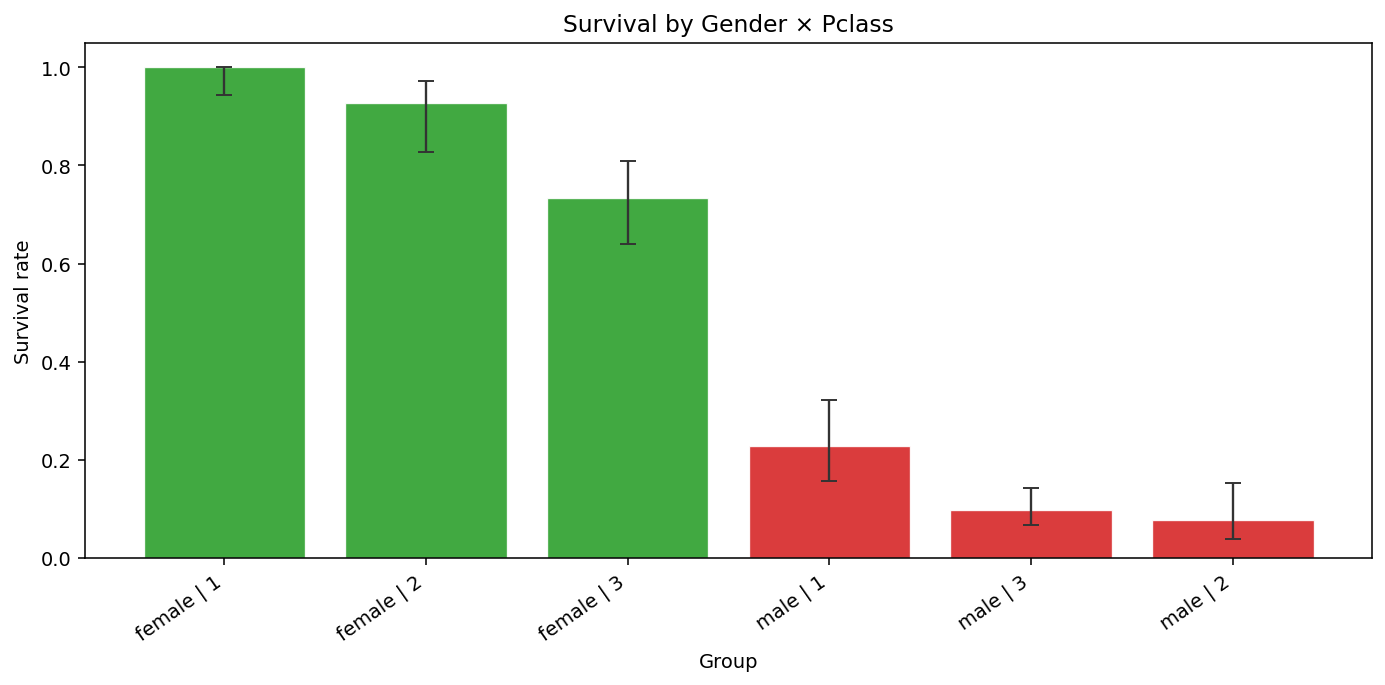

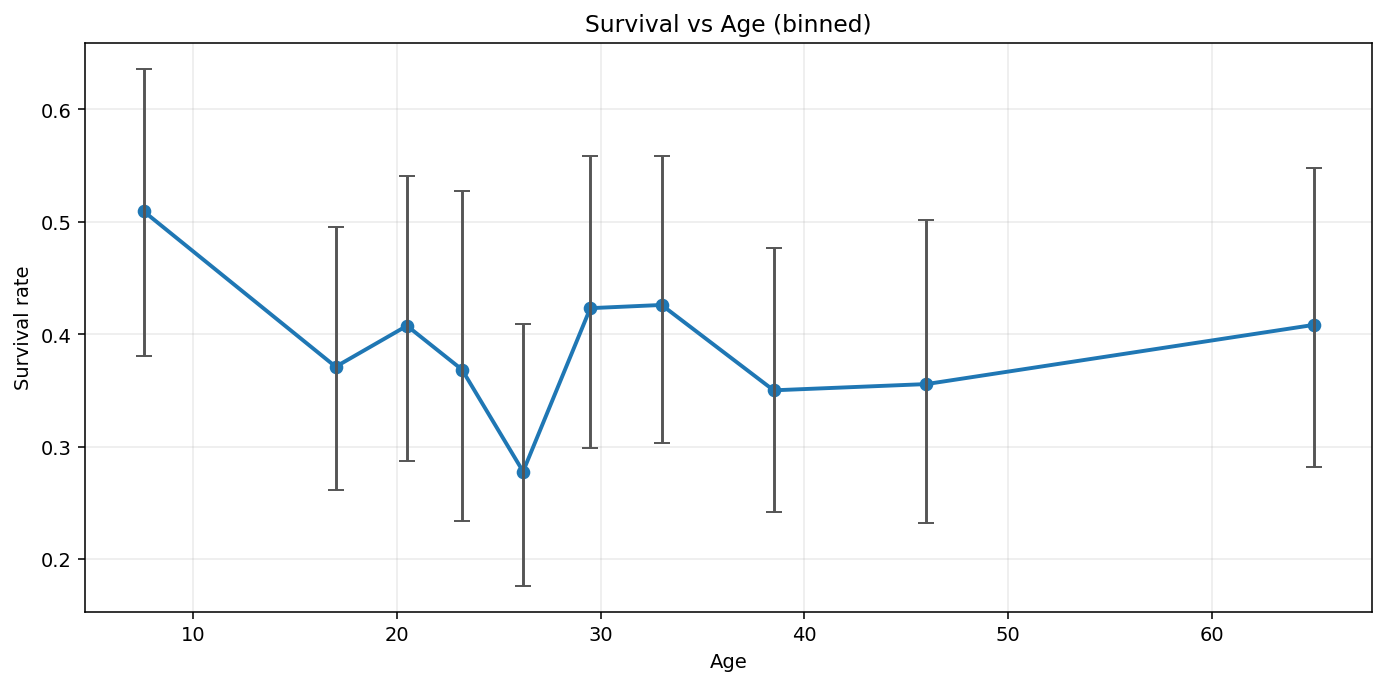

In [7]:
# =========================================================
# 5) 범용 EDA (언제든 실행 가능)
# =========================================================
def _pal(n): cmap=plt.cm.tab10; return [cmap(i%10) for i in range(n)]
def wilson_ci(k, n, z=1.96):
    if n==0: return np.nan, np.nan
    p=k/n; denom=1+z**2/n
    center=(p+z**2/(2*n))/denom
    half = z*np.sqrt((p*(1-p)+z**2/(4*n))/n)/denom
    return center-half, center+half

def _ci_to_yerr(y, ci_lo, ci_hi):
    """CI(lo,hi) → matplotlib yerr (2xN), 음수/NaN/역전 방지"""
    y   = np.asarray(y, dtype=float)
    lo  = np.asarray(ci_lo, dtype=float)
    hi  = np.asarray(ci_hi, dtype=float)

    # 1) 역전된 CI 교정
    swap = hi < lo
    lo, hi = np.where(swap, hi, lo), np.where(swap, lo, hi)

    # 2) NaN은 y로 대체(오류바 0)
    lo = np.where(np.isfinite(lo), lo, y)
    hi = np.where(np.isfinite(hi), hi, y)

    # 3) 오류바 계산 + 0 이하 클립(부동소수 오차 포함)
    lower = np.maximum(0.0, y - lo)
    upper = np.maximum(0.0, hi - y)

    return np.vstack([lower, upper])

def rate_table(df, y_col, group_cols, min_count=5, baseline=None):
    if isinstance(group_cols, str): group_cols=[group_cols]
    g = df.groupby(group_cols, dropna=False)[y_col]
    agg = g.agg(['count','sum']).reset_index().rename(columns={'count':'n','sum':'k'})
    agg['rate']=agg['k']/agg['n']
    ci = agg.apply(lambda r: wilson_ci(r['k'], r['n']), axis=1)
    agg['ci_lo']=[c[0] for c in ci]; agg['ci_hi']=[c[1] for c in ci]
    if baseline is None: baseline=df[y_col].mean()
    agg['lift']=agg['rate']/baseline
    agg = agg[agg['n']>=min_count].copy()
    agg['label']=agg[group_cols].astype(str).agg(' | '.join, axis=1)
    return agg.sort_values('lift', ascending=False), baseline

def rate_table_numeric(df, y_col, x_col, q=10, min_count=10):
    bins = pd.qcut(df[x_col], q=q, duplicates='drop')
    tmp=df.copy(); tmp[f'{x_col}_bin']=bins
    tab,_=rate_table(tmp, y_col, f'{x_col}_bin', min_count=min_count, baseline=None)
    def _mid(iv):
        try: return (iv.left+iv.right)/2
        except: return np.nan
    tab['x_mid']=tab[f'{x_col}_bin'].apply(_mid)
    return tab.sort_values('x_mid')

def plot_bar_ci(tab, title='', xlabel='Group', ylabel='Rate', color_mode='by_lift'):
    if tab is None or len(tab)==0:
        print("[plot_bar_ci] empty table."); return
    y = tab['rate'].values
    yerr = _ci_to_yerr(y, tab['ci_lo'].values, tab['ci_hi'].values)

    x = np.arange(len(tab))
    if color_mode=='by_lift' and 'lift' in tab.columns:
        colors = ['#2ca02c' if lv>=1.0 else '#d62728' for lv in tab['lift'].values]
    else:
        cmap = plt.cm.tab10; colors=[cmap(i%10) for i in range(len(tab))]

    plt.figure(figsize=(10,5))
    plt.bar(x, y, color=colors, edgecolor='white', linewidth=0.7, alpha=0.9)
    plt.errorbar(x, y, yerr=yerr, fmt='none', ecolor='#333', elinewidth=1.2, capsize=4)
    plt.xticks(x, tab['label'], rotation=35, ha='right')
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout(); plt.show()

def plot_line_ci(tab, title='', xlabel='Value', ylabel='Rate'):
    if tab is None or len(tab)==0:
        print("[plot_line_ci] empty table."); return
    y = tab['rate'].values
    yerr = _ci_to_yerr(y, tab['ci_lo'].values, tab['ci_hi'].values)  # ★ 여기
    x = tab['x_mid'].values

    plt.figure(figsize=(10,5))
    plt.plot(x, y, marker='o', linewidth=2.0)
    plt.errorbar(x, y, yerr=yerr, fmt='none', ecolor='#555', capsize=4)
    plt.grid(alpha=0.25); plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout(); plt.show()

# "원본 혹은 FE없는 상태"에서도 읽힘
_df_eda = X_tr.copy() if 'X_tr' in globals() else ori_train.drop(columns=['survived'])
if 'survived' in ori_train: _y = y_tr if 'y_tr' in globals() else ori_train['survived']
df_eda = _df_eda.copy(); df_eda['survived']=pd.Series(_y).astype(int).values
if 'age_bin' not in df_eda.columns and 'age' in df_eda.columns: df_eda['age_bin']=df_eda['age'].apply(lambda a: "child" if (pd.notna(a) and a<=12) else ("teen" if pd.notna(a) and a<=18 else ("adult" if pd.notna(a) and a<=60 else ("elderly" if pd.notna(a) else np.nan))))
if 'fare_bin' not in df_eda.columns and 'fare' in df_eda.columns: df_eda['fare_bin']=df_eda['fare'].apply(lambda f: "low" if (pd.notna(f) and f<10) else ("mid" if pd.notna(f) and f<30 else ("high" if pd.notna(f) else np.nan)))

print("== EDA numeric summary ==")
num = df_eda.select_dtypes(include='number')
print(pd.DataFrame({'kurtosis': num.apply(pd.Series.kurt),
                    'skewness': num.apply(pd.Series.skew)}).head(12))
if {'gender','pclass','survived'}.issubset(df_eda.columns):
    tab,_=rate_table(df_eda, 'survived', ['gender','pclass'])
    plot_bar_ci(tab, title='Survival by Gender × Pclass', xlabel='Group', ylabel='Survival rate')
if 'age' in df_eda.columns and df_eda['age'].notna().any():
    t=rate_table_numeric(df_eda, 'survived', 'age', q=10); plot_line_ci(t, title='Survival vs Age (binned)', xlabel='Age', ylabel='Survival rate')


# 6. Filleres - FE - Drop

In [8]:
# =========================================================
# 6) Fillers→FE→Drop (한 번에 재생성)
# =========================================================
fillers = compute_train_fillers(X_tr)
X_tr_f  = apply_fillers(X_tr, fillers)
X_te_f  = apply_fillers(X_te, fillers)
ori_te_f= apply_fillers(ori_test.copy(), fillers)

X_tr_f  = add_basic_fe(X_tr_f)
X_te_f  = add_basic_fe(X_te_f)
ori_te_f= add_basic_fe(ori_te_f)

fare_bins = pd.qcut(X_tr_f["fare"], q=3, retbins=True, duplicates="drop")[1]
ticket_counts = X_tr_f["ticket"].astype(str).value_counts()

X_tr_fe  = add_strong_fe(X_tr_f,  ticket_counts=ticket_counts, fare_bins=fare_bins)
X_te_fe  = add_strong_fe(X_te_f,  ticket_counts=ticket_counts, fare_bins=fare_bins)
ori_te_fe= add_strong_fe(ori_te_f, ticket_counts=ticket_counts, fare_bins=fare_bins)

X_tr_fe  = add_error_slice_fe(X_tr_fe,  ticket_counts=ticket_counts)
X_te_fe  = add_error_slice_fe(X_te_fe,  ticket_counts=ticket_counts)
ori_te_fe= add_error_slice_fe(ori_te_fe, ticket_counts=ticket_counts)

fare_edges = X_tr["fare"].quantile([0, 1/3, 2/3, 1]).to_numpy()
fare_edges[0] = -1e9
fare_edges[-1] = 1e9

for df in [X_tr_fe, X_te_fe, ori_te_fe]:
    df['fare_qcut'] = pd.cut(df['fare'],
                             bins=fare_edges,
                             labels=['low','mid','high'],
                             include_lowest=True)
    df['sex_fare_qcut'] = df['gender'].astype(str) + "_" + df['fare_qcut'].astype(str)


DROP_COLS = ['ticket','cabin','name','is_mother','deck_letter']
def _safe_drop(df, cols): return df.drop(columns=[c for c in cols if c in df.columns], errors='ignore').copy()

X_tr_d   = _safe_drop(X_tr_fe,   DROP_COLS)
X_te_d   = _safe_drop(X_te_fe,   DROP_COLS)
ori_te_d = _safe_drop(ori_te_fe, DROP_COLS)

print("[FE] shapes:", X_tr_d.shape, X_te_d.shape, ori_te_d.shape)
assert len(X_tr_d)==len(y_tr) and len(X_te_d)==len(y_te)


[FE] shapes: (641, 71) (275, 71) (393, 71)


# 7. 전처리 대상 컬럼 세트

In [9]:
# =========================================================
# 7) 전처리 대상 컬럼 세트
# =========================================================
REF = X_tr_d
num_cols = [c for c in ['age','fare','fam_size','fare_per_head','name_length',
                        'fare_div_pclass','age_x_pclass','fare_per_head_div_pclass',
                        'ticket_group_size','ticket_group_size_log1p',
                        'fare_log1p','fare_per_head_log1p','name_length_log1p'] if c in REF.columns]
bin_cols = [c for c in ['is_child','is_elderly','is_female','is_male','is_alone',
                        'female_child','female_elderly','male_child','male_elderly',
                        'female_pclass1','female_pclass2','female_pclass3',
                        'male_pclass1','male_pclass2','male_pclass3',
                        'is_child_male','is_master','child_pclass3',
                        'male_highfare','male_highfare_hi_class',
                        'age_30_34','age_35_44','age_45_54',
                        'male_35_44','female_35_44',
                        'fare_zero','fare_zero_pclass3','fare_zero_male','is_rare_title',
                        'is_with_family','female_with_family','male_with_family','master_with_family',
                        'female_p3_with_family','female_p3_has_cabin',
                        'has_cabin','shared_ticket'] if c in REF.columns]
cat_cols = [c for c in ['gender','embarked','pclass','deck_group','title','age_bin','fare_bin',
                        'sex_agebin','sex_farebin','fam_category','fare_qcut','sex_fare_qcut',
                        'ticket_prefix','sex_x_pclass','sex_x_fareq'] if c in REF.columns]
high_card_cols = [c for c in ['surname','ticket_str'] if c in REF.columns]

print("num:", len(num_cols), "bin:", len(bin_cols), "cat:", len(cat_cols), "te:", high_card_cols)


num: 13 bin: 37 cat: 15 te: ['surname', 'ticket_str']


# 8. 파이프라인 빌더

In [10]:
# =========================================================
# 8) 파이프라인 빌더 (clone-safe TE, OHE 호환)
# =========================================================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin

# OHE 호환
def make_ohe(drop):
    try:
        return OneHotEncoder(handle_unknown='ignore', drop=drop, sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', drop=drop, sparse=False)

# 안전 ColumnSelector
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
    def fit(self, X, y=None):
        X = pd.DataFrame(X); self._cols_ = list(X.columns) if (self.cols is None) else list(self.cols); return self
    def transform(self, X):
        X = pd.DataFrame(X)
        if not hasattr(self, "_cols_"):
            self._cols_ = list(X.columns) if (self.cols is None) else list(self.cols)
        keep = [c for c in self._cols_ if c in X.columns]
        return X[keep]

# clone-safe KFoldTargetEncoder
from sklearn.model_selection import KFold
class KFoldTargetEncoderCV(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, smoothing=20, n_splits=5, random_state=42, shuffle=True):
        self.cols=cols; self.smoothing=smoothing; self.n_splits=n_splits
        self.random_state=random_state; self.shuffle=shuffle
    def fit(self, X, y=None):
        if y is None: raise ValueError("y is required")
        X=pd.DataFrame(X); y=pd.Series(y).reset_index(drop=True)
        smoothing=float(self.smoothing); n_splits=int(self.n_splits)
        shuffle=bool(self.shuffle); rs=None if self.random_state is None else int(self.random_state)
        self.cols_ = list(self.cols) if self.cols is not None else list(X.columns)
        self._fit_index_ = X.index.copy(); self.global_mean_=float(y.mean())
        self.maps_ = {}; self._fit_oof_ = {}; kf=KFold(n_splits=n_splits, shuffle=shuffle, random_state=rs)
        for c in self.cols_:
            col = X[c].reset_index(drop=True); oof = np.full(len(X), np.nan, dtype=float)
            for tr,va in kf.split(X):
                grp = y.iloc[tr].groupby(col.iloc[tr]).agg(['sum','count'])
                enc = ((grp['sum'] + self.global_mean_*smoothing)/(grp['count']+smoothing)).to_dict()
                oof[va] = col.iloc[va].map(enc).astype(float).fillna(self.global_mean_).values
            oof[~np.isfinite(oof)] = self.global_mean_; self._fit_oof_[c]=oof
            full = y.groupby(col).agg(['sum','count'])
            self.maps_[c]=((full['sum'] + self.global_mean_*smoothing)/(full['count']+smoothing)).to_dict()
        return self
    def transform(self, X):
        X=pd.DataFrame(X); is_fit=X.index.equals(self._fit_index_); outs=[]
        for c in self.cols_:
            enc = (pd.Series(self._fit_oof_[c], index=X.index, dtype=float)
                   if is_fit else X[c].map(self.maps_[c]).astype(float).fillna(self.global_mean_))
            outs.append(enc.rename(f"te__{c}"))
        return pd.concat(outs, axis=1)
    def get_feature_names_out(self, input_features=None):
        return np.array([f"te__{c}" for c in self.cols_], dtype=object)

# 모델 팩토리
try:
    from xgboost import XGBClassifier
except Exception: XGBClassifier=None
try:
    from lightgbm import LGBMClassifier
except Exception: LGBMClassifier=None

def _scale_pos_weight(y):
    y=pd.Series(y); pos=(y==1).sum(); neg=(y==0).sum(); return float(neg/max(pos,1))

def build_base_model(fam):
    if fam=="logreg": return LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    if fam=="dt":     return DecisionTreeClassifier(random_state=RANDOM_STATE)
    if fam=="rf":     return RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
    if fam=="gbdt":   return GradientBoostingClassifier(random_state=RANDOM_STATE)
    if fam=="hgb":    return HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=None, learning_rate=0.05, max_leaf_nodes=31, min_samples_leaf=20)
    if fam=="xgb":
        if XGBClassifier is None: raise ImportError("pip install xgboost")
        return XGBClassifier(n_estimators=600, max_depth=4, learning_rate=0.05,
                             subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
                             min_child_weight=1.0, tree_method="hist",
                             random_state=RANDOM_STATE, n_jobs=-1, eval_metric="auc")
    if fam=="lgbm":
        if LGBMClassifier is None: raise ImportError("pip install lightgbm")
        return LGBMClassifier(n_estimators=800, num_leaves=31, learning_rate=0.05,
                              subsample=0.8, colsample_bytree=0.8, reg_lambda=0.0,
                              random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1)
    raise ValueError(fam)

def build_selector(mode):
    if mode=="none": return None
    if mode=="l1":
        return SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=0.5,
                                                  max_iter=2000, random_state=RANDOM_STATE),
                               max_features=30, threshold=-float('inf'))
    if mode=="rfecv":
        return RFECV(estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                     step=1, cv=5, scoring='accuracy', min_features_to_select=10)
    if mode=="kbest": return SelectKBest(score_func=mutual_info_classif, k=30)
    raise ValueError

def build_preprocessor(fam, num_cols, bin_cols, cat_cols, use_te=False, te_cols=None, ohe_drop="if_binary"):
    num_cols, bin_cols, cat_cols = list(num_cols), list(bin_cols), list(cat_cols)
    te_cols = list(te_cols) if te_cols else None
    num_branch = Pipeline([('imp', SimpleImputer(strategy='median')),
                           ('scaler', RobustScaler())]) if fam in ("logreg",) else SimpleImputer(strategy='median')
    ct = ColumnTransformer(
        transformers=[
            ('num', num_branch, num_cols),
            ('bin', SimpleImputer(strategy='constant', fill_value=0), bin_cols),
            ('cat', make_ohe(ohe_drop), cat_cols),
        ], remainder='drop'
    )
    ohe_branch = Pipeline([('sel', ColumnSelector(num_cols+bin_cols+cat_cols)),
                           ('ct', ct)])
    if use_te and te_cols:
        te_branch = Pipeline([('sel', ColumnSelector(te_cols)),
                              ('te', KFoldTargetEncoderCV(cols=te_cols, smoothing=20, n_splits=5, random_state=RANDOM_STATE))])
        return FeatureUnion([('ohe', ohe_branch), ('te', te_branch)])
    return ohe_branch

def build_clf(fam, select_mode, num_cols, bin_cols, cat_cols, use_te=False, te_cols=None, ohe_drop="if_binary"):
    prep = build_preprocessor(fam, num_cols, bin_cols, cat_cols, use_te=use_te, te_cols=te_cols, ohe_drop=ohe_drop)
    model = build_base_model(fam)
    sel = build_selector(select_mode)
    steps=[('prep',prep)]
    if sel is not None: steps.append(('fs', sel))
    steps.append(('model', model))
    return Pipeline(steps)

SELECT_MODE="none"; MODEL_FAMILY="xgb"; USE_TE=bool(high_card_cols); OHE_DROP="if_binary"
clf = build_clf(MODEL_FAMILY, SELECT_MODE, num_cols, bin_cols, cat_cols, use_te=USE_TE, te_cols=high_card_cols, ohe_drop=OHE_DROP)


# 8-2 Hyperparameter Tuning

In [13]:
# =========================================================
# 8-3) 빠른 탐색(RandomizedSearchCV) — 성능↑/시간↓
# =========================================================
from sklearn.model_selection import StratifiedKFold, GroupKFold, RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import loguniform, uniform

def _use_group_cv():
    return (groups_tr is not None) and (len(groups_tr)==len(y_tr))

# =================== 파라미터 값 조정 =========================
param_dist = {} 
if MODEL_FAMILY=="xgb":
    param_dist = {
        "model__max_depth": [3,4,5],
        "model__min_child_weight": loguniform(1, 30),
        "model__learning_rate": loguniform(0.02, 0.15),
        "model__n_estimators": [400,800,1200],
        "model__subsample": uniform(0.7, 0.3),
        "model__colsample_bytree": uniform(0.7, 0.3),
        "model__reg_lambda": loguniform(1e-3, 10),
        "model__gamma": loguniform(1e-4, 1),
        "model__reg_alpha": loguniform(1e-4, 1),
        "model__scale_pos_weight": [1.0, float(_scale_pos_weight(y_tr))],
    }
elif MODEL_FAMILY=="lgbm":
    param_dist = {
        "model__n_estimators": [600, 1000, 1500],
        "model__num_leaves": [31, 63],
        "model__max_depth": [-1, 6, 10],
        "model__min_child_samples": [10, 20, 40],
        "model__learning_rate": loguniform(0.02, 0.1),
        "model__subsample": uniform(0.7, 0.3),
        "model__colsample_bytree":uniform(0.7, 0.3),
        "model__reg_lambda": loguniform(1e-3, 10),
        "model__lambda_l1": loguniform(1e-4, 1),
    }
if USE_TE and MODEL_FAMILY in ("xgb","lgbm","hgb","rf","dt"):
    param_dist["prep__te__te__smoothing"] = [10, 20, 50]
if MODEL_FAMILY in ("xgb","lgbm"):
    spw = _scale_pos_weight(y_tr)
    param_dist["model__scale_pos_weight"] = [1.0, float(spw)]

# ============ 1. 함수 정의 ==============
def run_rs_for_seeds(clf, param_dist, seeds, n_iter=50):
    rows, models, tried_by_seed, rs_objects = [], {}, {}, {}
    for seed in seeds:
        cv = GroupKFold(5) if _use_group_cv() else StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        rs = RandomizedSearchCV(
            clf, param_distributions=param_dist, n_iter=n_iter, cv=cv,
            scoring="roc_auc", n_jobs=-1, random_state=seed, refit=True, verbose=2
        )
        sw = compute_sample_weight(class_weight="balanced", y=y_tr)
        fit_kwargs = {"groups": groups_tr} if _use_group_cv() else {}
        rs.fit(X_tr_d, y_tr, model__sample_weight=sw, **fit_kwargs)

        rows.append({"seed": seed, "cv_auc": rs.best_score_, "best_params": rs.best_params_})
        models[seed] = rs.best_estimator_
        tried_by_seed[seed] = pd.DataFrame(rs.cv_results_["params"])
        rs_objects[seed] = rs

        print(f"[Seed={seed}] best AUC: {rs.best_score_:.4f}")
        print(f"[Seed={seed}] best params: {rs.best_params_}")

    return pd.DataFrame(rows), models, tried_by_seed, rs_objects



# ============ 2. 실행 ==============
seeds = [50, 123, 150]   # 원하는 seed 리스트
df_runs, best_models, tried_by_seed = run_rs_for_seeds(clf, param_dist, seeds, n_iter=50)

print(df_runs)

# ============ 3. 가장 높은 CV AUC의 seed 선택 후 clf 교체 ==============
best_seed = int(df_runs.loc[df_runs['cv_auc'].idxmax(), 'seed'])
clf = best_models[best_seed]
print(f"[Adopt best model] seed={best_seed}, cv_auc={df_runs['cv_auc'].max():.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__colsample_bytree=0.8317915164229449, model__gamma=0.0003460619769141374, model__learning_rate=0.06629019232393019, model__max_depth=5, model__min_child_weight=27.33654847728197, model__n_estimators=800, model__reg_alpha=0.017371143778154362, model__reg_lambda=0.017962343032354795, model__scale_pos_weight=1.0, model__subsample=0.713791310059815, prep__te__te__smoothing=50; total time=   0.2s
[CV] END model__colsample_bytree=0.8317915164229449, model__gamma=0.0003460619769141374, model__learning_rate=0.06629019232393019, model__max_depth=5, model__min_child_weight=27.33654847728197, model__n_estimators=800, model__reg_alpha=0.017371143778154362, model__reg_lambda=0.017962343032354795, model__scale_pos_weight=1.0, model__subsample=0.713791310059815, prep__te__te__smoothing=50; total time=   0.2s
[CV] END model__colsample_bytree=0.8317915164229449, model__gamma=0.0003460619769141374, model__learning_rate=0.066290

ValueError: too many values to unpack (expected 3)


[best seed=123] model__max_depth coverage
model__max_depth
5    19
4    17
3    14
Name: count, dtype: int64

[best seed=123] model__n_estimators coverage
model__n_estimators
400     18
1200    16
800     16
Name: count, dtype: int64

[best seed=123] model__scale_pos_weight coverage
model__scale_pos_weight
1.64876    27
1.00000    23
Name: count, dtype: int64


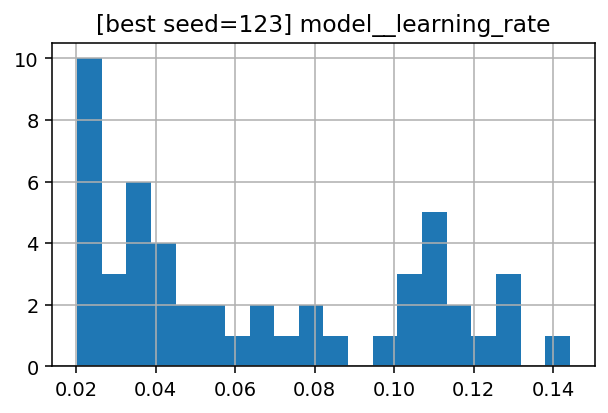

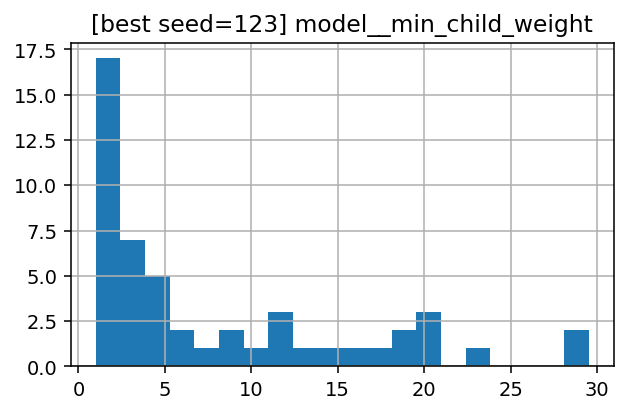

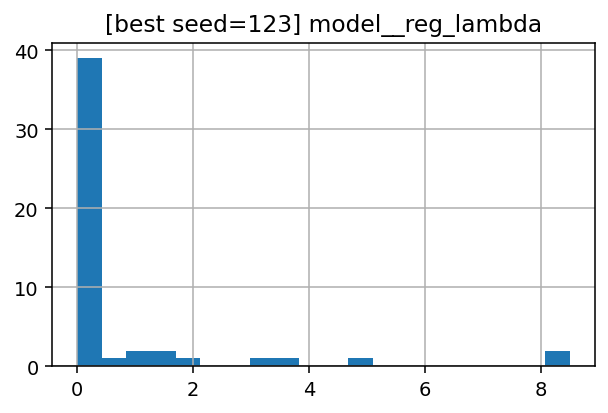

In [ ]:
tried = tried_by_seed[best_seed]

for c in ["model__max_depth", "model__n_estimators", "model__scale_pos_weight"]:
    if c in tried.columns:
        print(f"\n[best seed={best_seed}] {c} coverage")
        print(tried[c].value_counts())

for c in ["model__learning_rate","model__min_child_weight","model__reg_lambda"]:
    if c in tried.columns:
        plt.figure(figsize=(5,3))
        plt.hist(pd.to_numeric(tried[c], errors="coerce").dropna(), bins=20)
        plt.title(f"[best seed={best_seed}] {c}")
        plt.grid(True)
        plt.show()

In [ ]:
tried = pd.DataFrame(rs.cv_results_["params"])
print(tried["model__max_depth"].value_counts())
print(tried["model__n_estimators"].value_counts())
print(tried["model__scale_pos_weight"].value_counts())

NameError: name 'rs' is not defined

In [ ]:
tried["model__learning_rate"].hist(bins=20)


# 9.CV & Hold-out

In [ ]:
# =========================================================
# 9) CV & Hold-out 평가
# =========================================================
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# 컬럼 정합 보장(혹시 모를 순서 차이)
X_tr_d, X_te_d = align_columns_pair(X_tr_d.copy(), X_te_d.copy())

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_acc = cross_val_score(clf, X_tr_d, y_tr, cv=cv, scoring='accuracy')
print(f"[CV] accuracy: {np.round(cv_acc,4)} (mean={cv_acc.mean():.4f})")
try:
    cv_auc = cross_val_score(clf, X_tr_d, y_tr, cv=cv, scoring='roc_auc')
    print(f"[CV] roc_auc : {np.round(cv_auc,4)} (mean={cv_auc.mean():.4f})")
except Exception:
    print("[CV] roc_auc : skipped")

clf.fit(X_tr_d, y_tr)
y_pred = clf.predict(X_te_d)
print(f"[Hold-out] acc={accuracy_score(y_te,y_pred):.4f}")
print(confusion_matrix(y_te, y_pred))
print(classification_report(y_te, y_pred, digits=4, zero_division=0))
try:
    if hasattr(clf,"predict_proba"):
        y_score = clf.predict_proba(X_te_d)[:,1]
    elif hasattr(clf,"decision_function"):
        y_score = clf.decision_function(X_te_d)
    else:
        y_score = None
    if y_score is not None:
        print("[Hold-out] AUC:", roc_auc_score(y_te, y_score))
except Exception as e:
    print("[Hold-out] AUC skipped:", e)


[CV] accuracy: [0.8915 0.8594 0.8672 0.8438 0.875 ] (mean=0.8674)
[CV] roc_auc : [0.9122 0.9057 0.8659 0.8504 0.916 ] (mean=0.8901)
[Hold-out] acc=0.8400
[[150  21]
 [ 23  81]]
              precision    recall  f1-score   support

           0     0.8671    0.8772    0.8721       171
           1     0.7941    0.7788    0.7864       104

    accuracy                         0.8400       275
   macro avg     0.8306    0.8280    0.8293       275
weighted avg     0.8395    0.8400    0.8397       275

[Hold-out] AUC: 0.9058704453441295


# 10. 임계값 튜닝(Threshold)

In [ ]:
# =========================================================
# 10) 임계값 튜닝 (F1 기본)
# =========================================================
from sklearn.metrics import precision_recall_curve, f1_score, balanced_accuracy_score

def tune_threshold(scores, y_true, metric="f1"):
    q_lo, q_hi = np.quantile(scores, 0.05), np.quantile(scores, 0.95)
    thresholds = np.linspace(q_lo, q_hi, 101) if q_lo<q_hi else np.array([q_lo])
    def _metric(y, yhat):
        if metric=="f1": return f1_score(y,yhat)
        if metric=="balanced_accuracy": return balanced_accuracy_score(y,yhat)
        if metric=="accuracy": return accuracy_score(y,yhat)
        # Youden J
        cm = confusion_matrix(y, yhat, labels=[0,1]); tn,fp,fn,tp = cm.ravel()
        tpr = tp/(tp+fn+1e-12); tnr = tn/(tn+fp+1e-12); return tpr+tnr-1
    best_t, best_v = None, -np.inf
    for t in thresholds:
        yhat = (scores>=t).astype(int); v=_metric(y_true, yhat)
        if v>best_v: best_v, best_t = v, t
    return float(best_t), float(best_v)

TARGET="f1"
if hasattr(clf,"predict_proba"):
    score = clf.predict_proba(X_te_d)[:,1]; THRESH_BASIS="proba"
elif hasattr(clf,"decision_function"):
    score = clf.decision_function(X_te_d); THRESH_BASIS="score"
else:
    score=None; THRESH_BASIS=None

if score is not None:
    THRESH, best_val = tune_threshold(score, y_te, metric=TARGET)
    print(f"[Tuning] basis={THRESH_BASIS}, metric={TARGET}, best_t={THRESH:.3f}, val={best_val:.4f}")
    y_tuned = (score>=THRESH).astype(int)
    print(f"[Hold-out @{THRESH_BASIS}≥{THRESH:.3f}] acc={accuracy_score(y_te,y_tuned):.4f}")
else:
    THRESH=None

# 저장용
class _Args: pass
args = _Args()
args.thresh_basis = THRESH_BASIS
args.thresh = THRESH


[Tuning] basis=proba, metric=f1, best_t=0.633, val=0.8000
[Hold-out @proba≥0.633] acc=0.8545


# 11. 중요한 Feature 추출

In [ ]:
# =========================================================
# 11) 전처리 후 피처명 + 12) 중요도 (fit 상태 보장)
# =========================================================
from sklearn.utils.validation import check_is_fitted
from sklearn.ensemble import RandomForestClassifier

prep = clf.named_steps['prep']
try:
    check_is_fitted(prep)
except Exception:
    prep.fit(X_tr_d, y_tr)

def _to_dense(X): return X.toarray() if hasattr(X,"toarray") else X

Xtr_pre = _to_dense(prep.transform(X_tr_d))
feat_names = [f"f{i}" for i in range(Xtr_pre.shape[1])]  # 간단화: 필요 시 상세 추출 함수로 교체 가능
X_tr_final = pd.DataFrame(Xtr_pre, columns=feat_names, index=X_tr_d.index)

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_tr_final, y_tr)
fi_df = (pd.DataFrame({'feature': feat_names, 'importance': rf.feature_importances_})
         .sort_values('importance', ascending=False))
print("[Top15] transformed feature importances:")
print(fi_df.head(15))


[Top15] transformed feature importances:
   feature  importance
15     f15    0.077024
16     f16    0.068717
50     f50    0.060959
77     f77    0.047733
63     f63    0.045341
12     f12    0.040407
6       f6    0.036013
4       f4    0.035018
73     f73    0.034221
0       f0    0.032455
7       f7    0.025542
3       f3    0.024821
62     f62    0.024556
5       f5    0.024499
1       f1    0.024129


# 12. EDA-2

[Feature Importance] source = model.feature_importances_


,feature,importance
0,bin__is_male,0.288634
1,bin__is_female,0.185926
2,cat__gender_male,0.040863
3,cat__title_Mr,0.027650
4,bin__female_p3_with_family,0.027300
5,bin__is_master,0.019172
6,bin__has_cabin,0.016713
7,te__ticket_str,0.016055
8,bin__shared_ticket,0.015973
9,cat__sex_agebin_female_adult,0.012714


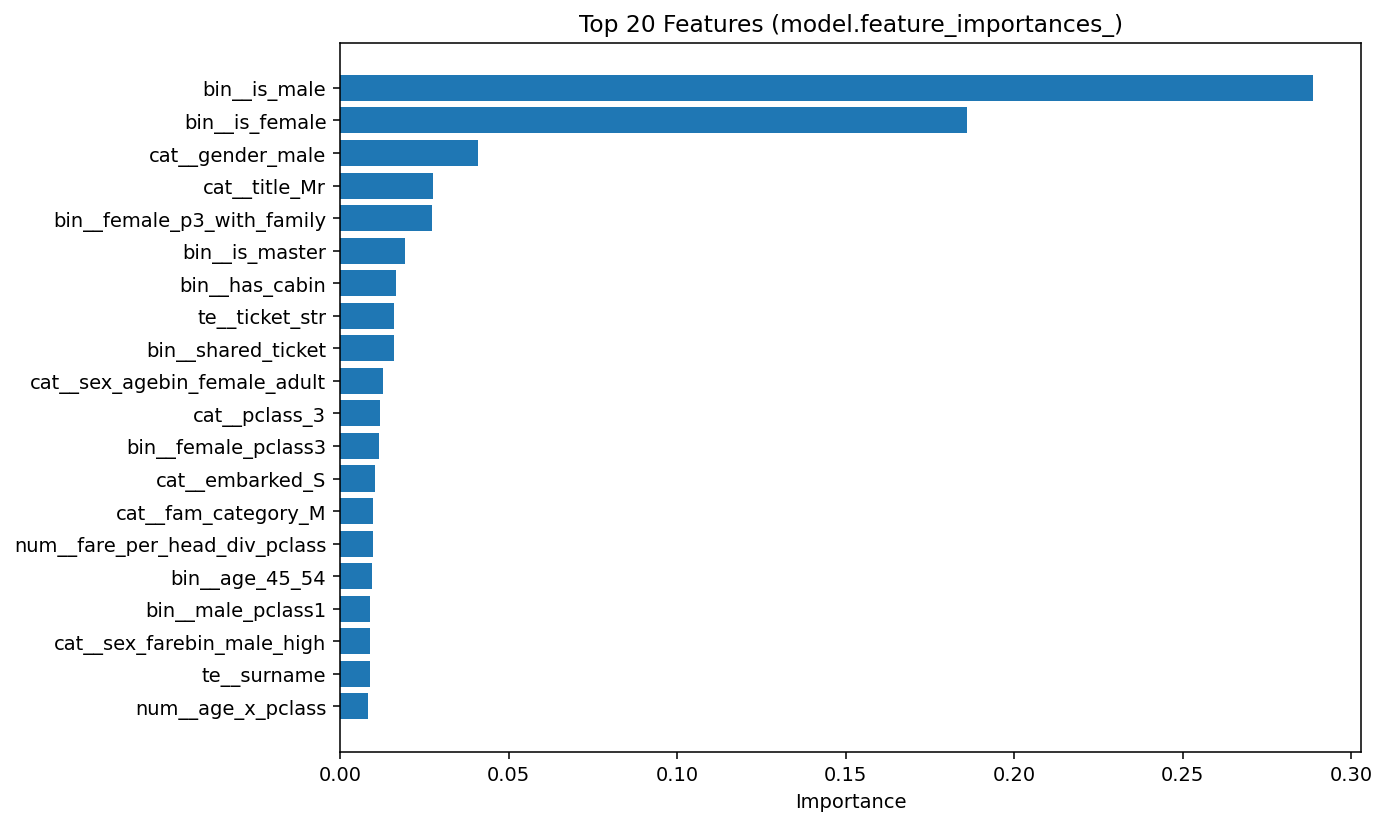

In [ ]:
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline as _P, FeatureUnion as _FU
from sklearn.compose import ColumnTransformer as _CT
from sklearn.exceptions import NotFittedError
from sklearn.inspection import permutation_importance

# ---- (A) 전처리 피처명 안전 추출 (FeatureUnion(OHE/TE) 지원) ----
def _names_from_ct(ct: _CT):
    try:
        return list(ct.get_feature_names_out())
    except Exception:
        names=[]
        for name, trans, cols in ct.transformers_:
            if name=='remainder' and trans=='drop':
                continue
            last = trans.steps[-1][1] if isinstance(trans, _P) else trans
            if hasattr(last, 'get_feature_names_out'):
                try:
                    names += list(last.get_feature_names_out(cols)); continue
                except Exception:
                    pass
            names += list(cols)
        return names

def get_prep_feature_names(prep):
    # ColumnTransformer 단독
    if isinstance(prep, _CT):
        return _names_from_ct(prep)

    # Pipeline 내부에서 ColumnTransformer 찾기
    if isinstance(prep, _P):
        for _, step in reversed(prep.steps):
            if isinstance(step, _CT):
                return _names_from_ct(step)
            if hasattr(step, 'get_feature_names_out'):
                try:
                    return list(step.get_feature_names_out())
                except Exception:
                    pass
        # 파이프라인 안에 또 파이프라인이 있을 수도 있으니 재귀
        for _, step in reversed(prep.steps):
            if isinstance(step, _P):
                names = get_prep_feature_names(step)
                if names: return names
        return []

    # FeatureUnion(ohe + te)
    if isinstance(prep, _FU):
        names=[]
        tdict = dict(prep.transformer_list)

        # OHE 브랜치: Pipeline(sel -> ct)
        ohe = tdict.get('ohe')
        if isinstance(ohe, _P):
            for _, s in reversed(ohe.steps):
                if isinstance(s, _CT):
                    names += _names_from_ct(s); break

        # TE 브랜치: te.cols_ (fit 후) 또는 te.cols
        te = tdict.get('te')
        if isinstance(te, _P) and 'te' in te.named_steps:
            te_est = te.named_steps['te']
            te_cols = getattr(te_est, 'cols_', None) or getattr(te_est, 'cols', [])
            # 네 코드의 TE 클래스 이름이 달라도 prefix는 te__로 통일
            names += [f"te__{c}" for c in list(te_cols)]
        return names

    # 알 수 없는 타입
    return []

def _to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

# ---- (B) 전처리 행렬과 최종 컬럼명(선택적 FS 반영) 얻기 ----
def get_transformed_X_and_names(clf, X):
    prep = clf.named_steps['prep']
    try:
        check_is_fitted(prep)
    except Exception:
        try:
            _ = prep.transform(X.head(1))
        except NotFittedError:
            clf.fit(X, y_tr)  # 안전: 아직이면 한 번 학습시켜서 prep fit
            prep = clf.named_steps['prep']

    X_pre = _to_dense(prep.transform(X))
    feat_names = get_prep_feature_names(prep)

    if X_pre.shape[1] != len(feat_names) or len(feat_names)==0:
        # 이름 추출 실패 시 generic
        feat_names = [f"f{i}" for i in range(X_pre.shape[1])]

    # Feature Selection이 있으면 마스크/변환 반영
    if 'fs' in clf.named_steps:
        sel = clf.named_steps['fs']
        try:
            mask = sel.get_support()
            feat_names = [n for n, m in zip(feat_names, mask) if m]
            X_pre = sel.transform(X_pre)
        except Exception:
            # 지원하지 않는 선택기면 무시
            pass

    return np.asarray(X_pre), list(feat_names)

# ---- (C) 중요도 산출: model.importances_ 우선, 불가시 Permutation ----
def feature_importance_report(clf, X, y, topk=30, scoring="roc_auc", random_state=42):
    # 1) 모델 기반 중요도 시도
    model = clf.named_steps['model']
    X_mat, names = get_transformed_X_and_names(clf, X)

    use_model_importance = hasattr(model, "feature_importances_") and \
                           len(getattr(model, "feature_importances_")) == X_mat.shape[1]
    if use_model_importance:
        imps = np.asarray(model.feature_importances_, dtype=float)
        src = "model.feature_importances_"
    else:
        # 2) Permutation importance (느리지만 안전)
        rng = np.random.RandomState(random_state)
        pi = permutation_importance(clf, X, y, n_repeats=10, scoring=scoring,
                                    random_state=rng, n_jobs=-1)
        imps = np.asarray(pi.importances_mean, dtype=float)
        src = "permutation_importance"

    fi = (pd.DataFrame({"feature": names, "importance": imps})
            .sort_values("importance", ascending=False)
            .reset_index(drop=True))
    return fi, src

# ---- (D) 실행 & 시각화 ----
fi_df, src_used = feature_importance_report(clf, X_tr_d, y_tr, topk=30)

print(f"[Feature Importance] source = {src_used}")
display(fi_df.head(30))

# 깔끔한 막대 그래프 (상위 20개)
topn = min(20, len(fi_df))
plt.figure(figsize=(10, 6))
plt.barh(fi_df['feature'].head(topn)[::-1], fi_df['importance'].head(topn)[::-1])
plt.xlabel("Importance"); plt.title(f"Top {topn} Features ({src_used})")
plt.tight_layout(); plt.show()
# ========= /12) 끝 =========


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

def slice_report(X, y_true, proba, by):
    df = X[[by]].copy()
    df["y"] = np.asarray(y_true, dtype=int)
    df["p"] = np.asarray(proba, dtype=float)
    df["pred"] = (df["p"]>=0.5).astype(int)
    out=[]
    for val, g in df.groupby(by):
        if len(g) < 15: 
            continue
        auc_v = roc_auc_score(g["y"], g["p"]) if g["y"].nunique()==2 else np.nan
        acc_v = accuracy_score(g["y"], g["pred"])
        out.append({"slice": f"{by}={val}", "n": len(g),
                    "acc": acc_v, "auc": auc_v,
                    "pos_rate": g["y"].mean(), "pred_pos_rate": g["pred"].mean()})
    return pd.DataFrame(out).sort_values(["auc","acc"], ascending=[True, True], na_position="last")

# Holdout = X_te_d / y_te
if hasattr(clf, "predict_proba"):
    proba_hold = clf.fit(X_tr_d, y_tr).predict_proba(X_te_d)[:,1]
elif hasattr(clf, "decision_function"):
    proba_hold = clf.fit(X_tr_d, y_tr).decision_function(X_te_d)
else:
    proba_hold = clf.fit(X_tr_d, y_tr).predict(X_te_d).astype(float)

for by in ["gender","pclass","fare_qcut","age_bin","title","sex_agebin","sex_fare_qcut","deck_group","fam_category"]:
    if by in X_te_d.columns:
        print("\n===", by, "===")
        display(slice_report(X_te_d, y_te, proba_hold, by).head(10))



=== gender ===


,slice,n,acc,auc,pos_rate,pred_pos_rate
1,gender=male,169,0.869822,0.743565,0.124260,0.041420
0,gender=female,106,0.792453,0.796228,0.783019,0.896226



=== pclass ===


,slice,n,acc,auc,pos_rate,pred_pos_rate
2,pclass=3,160,0.800000,0.845036,0.262500,0.287500
0,pclass=1,66,0.848485,0.886364,0.666667,0.575758
1,pclass=2,49,0.959184,0.982079,0.367347,0.367347



=== fare_qcut ===


,slice,n,acc,auc,pos_rate,pred_pos_rate
0,fare_qcut=low,104,0.855769,0.855523,0.250000,0.240385
2,fare_qcut=high,88,0.818182,0.896902,0.590909,0.545455
1,fare_qcut=mid,83,0.843373,0.904858,0.313253,0.349398



=== age_bin ===


,slice,n,acc,auc,pos_rate,pred_pos_rate
1,age_bin=child,19,0.789474,0.886364,0.421053,0.526316
0,age_bin=adult,238,0.844538,0.902873,0.373950,0.352941



=== title ===


,slice,n,acc,auc,pos_rate,pred_pos_rate
1,title=Mr,157,0.872611,0.732265,0.121019,0.019108
0,title=Miss,60,0.750000,0.783704,0.750000,0.900000
2,title=Mrs,45,0.844444,0.800676,0.822222,0.888889



=== sex_agebin ===


,slice,n,acc,auc,pos_rate,pred_pos_rate
1,sex_agebin=male_adult,151,0.867550,0.722488,0.125828,0.019868
0,sex_agebin=female_adult,87,0.804598,0.776471,0.804598,0.931034



=== sex_fare_qcut ===


,slice,n,acc,auc,pos_rate,pred_pos_rate
1,sex_fare_qcut=female_low,26,0.692308,0.533835,0.730769,0.961538
4,sex_fare_qcut=male_low,78,0.910256,0.635815,0.089744,0.000000
5,sex_fare_qcut=male_mid,51,0.921569,0.666667,0.058824,0.058824
2,sex_fare_qcut=female_mid,32,0.718750,0.690821,0.718750,0.812500
3,sex_fare_qcut=male_high,40,0.725000,0.727273,0.275000,0.100000
0,sex_fare_qcut=female_high,48,0.895833,0.864111,0.854167,0.916667



=== deck_group ===


,slice,n,acc,auc,pos_rate,pred_pos_rate
0,deck_group=ABC,30,0.866667,0.830000,0.666667,0.600000
1,deck_group=DEF,28,0.821429,0.877193,0.678571,0.571429
2,deck_group=M,216,0.837963,0.896587,0.296296,0.310185



=== fam_category ===


,slice,n,acc,auc,pos_rate,pred_pos_rate
0,fam_category=L,23,0.782609,0.866071,0.304348,0.347826
1,fam_category=M,92,0.826087,0.898674,0.521739,0.543478
2,fam_category=S,160,0.856250,0.901636,0.306250,0.275000


## Overfitting Diagnostics

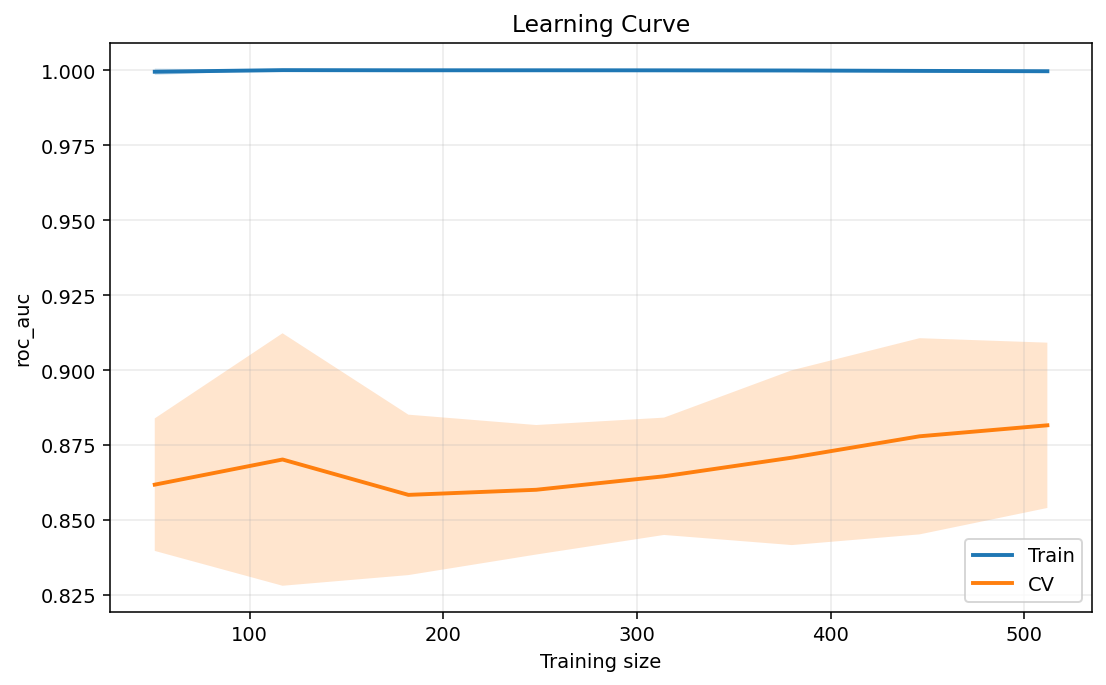

[CV] roc_auc  train=0.9996  val=0.8809  gap=0.1188  (std val=0.0265)


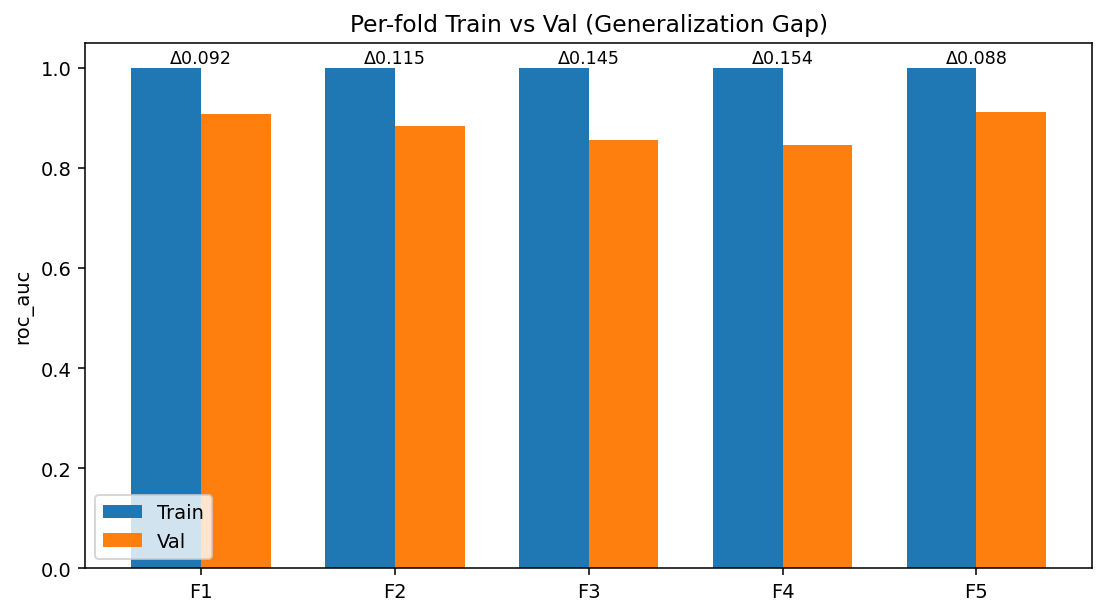

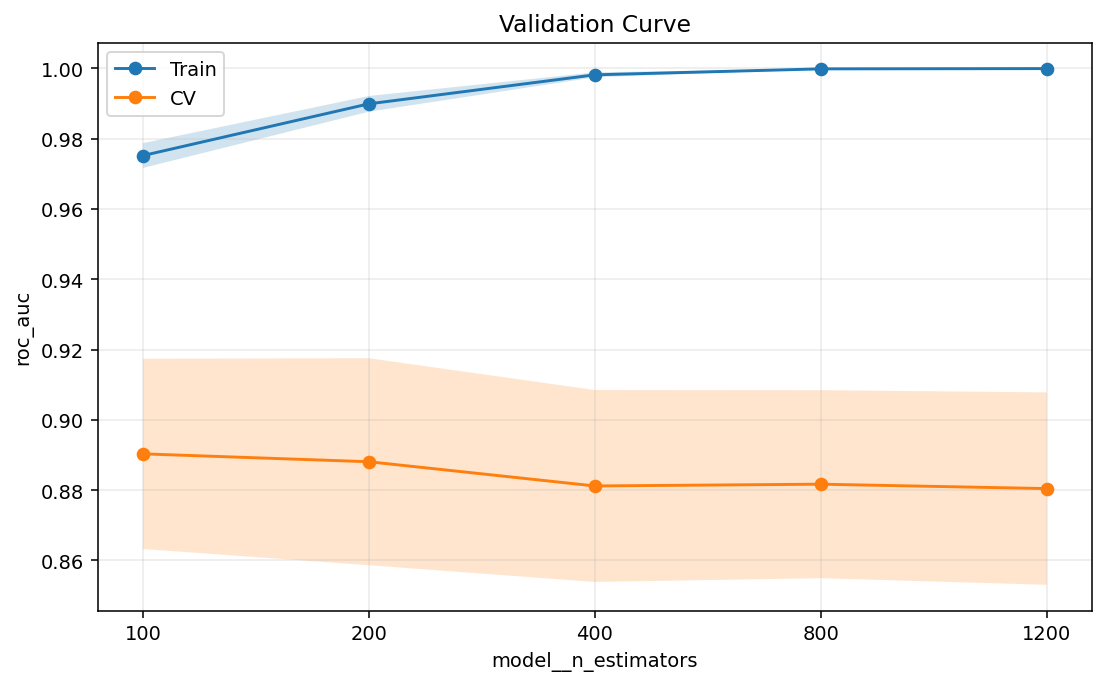

In [ ]:
# ==== Overfitting Diagnostics Dashboard (fixed) ====
import numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import (StratifiedKFold, GroupKFold,
                                     learning_curve, cross_validate, validation_curve)
from sklearn.base import clone

SCORING = "roc_auc"   # 없으면 "accuracy"로 바꿔도 OK
RANDOM_STATE = 42

use_group = 'groups_tr' in globals() and (groups_tr is not None) and (len(groups_tr)==len(y_tr))
cv = GroupKFold(n_splits=5) if use_group else StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_groups = groups_tr if use_group else None

# 1) Learning Curve (수정: 전치 제거, axis=1 평균)
est_lc = clone(clf)
train_sizes, train_scores, val_scores = learning_curve(
    est_lc, X_tr_d, y_tr,
    cv=cv, groups=cv_groups, scoring=SCORING,
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 8),
    shuffle=True  # 버전 호환 위해 random_state는 생략
)

tr_mean, tr_std = train_scores.mean(axis=1), train_scores.std(axis=1)
va_mean, va_std = val_scores.mean(axis=1), val_scores.std(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, tr_mean, label="Train", linewidth=2)
plt.fill_between(train_sizes, tr_mean-tr_std, tr_mean+tr_std, alpha=0.2)
plt.plot(train_sizes, va_mean, label="CV", linewidth=2)
plt.fill_between(train_sizes, va_mean-va_std, va_mean+va_std, alpha=0.2)
plt.xlabel("Training size"); plt.ylabel(SCORING); plt.title("Learning Curve")
plt.legend(); plt.grid(alpha=0.25); plt.tight_layout(); plt.show()

# 2) Per-fold Train vs Val (Generalization Gap)
est_cv = clone(clf)
cvres = cross_validate(
    est_cv, X_tr_d, y_tr, cv=cv, groups=cv_groups, scoring=SCORING,
    return_train_score=True, n_jobs=-1
)
gap = cvres["train_score"] - cvres["test_score"]
print(f"[CV] {SCORING}  train={cvres['train_score'].mean():.4f}  "
      f"val={cvres['test_score'].mean():.4f}  gap={gap.mean():.4f}  "
      f"(std val={cvres['test_score'].std():.4f})")

plt.figure(figsize=(8,4.5))
x = np.arange(len(cvres["test_score"]))
plt.bar(x-0.18, cvres["train_score"], width=0.36, label="Train")
plt.bar(x+0.18, cvres["test_score"], width=0.36, label="Val")
for i, g in enumerate(gap):
    plt.text(i, max(cvres["train_score"][i], cvres["test_score"][i]) + 0.01, f"Δ{g:.3f}", ha='center', fontsize=9)
plt.xticks(x, [f"F{i+1}" for i in x]); plt.ylim(0, 1.05)
plt.ylabel(SCORING); plt.title("Per-fold Train vs Val (Generalization Gap)")
plt.legend(); plt.tight_layout(); plt.show()

# 3) Validation Curve (핵심 하이퍼파라미터 스윕)
if hasattr(clf.named_steps['model'], 'get_params'):
    if 'xgb' in type(clf.named_steps['model']).__name__.lower():
        param_name = "model__n_estimators"; param_range = [100, 200, 400, 800, 1200]
    elif 'lgbm' in type(clf.named_steps['model']).__name__.lower():
        param_name = "model__num_leaves"; param_range = [15, 31, 63, 127]
    else:
        param_name = "model__max_depth" if "model__max_depth" in clf.get_params() else None
        param_range = [2, 3, 4, 6, 8, None] if param_name else None

    if param_name and param_range:
        est_vc = clone(clf)
        tr, va = validation_curve(est_vc, X_tr_d, y_tr,
                                  param_name=param_name, param_range=param_range,
                                  cv=cv, groups=cv_groups, scoring=SCORING, n_jobs=-1)
        tr_m, tr_s = tr.mean(axis=1), tr.std(axis=1)
        va_m, va_s = va.mean(axis=1), va.std(axis=1)

        xs = [str(v) for v in param_range]
        plt.figure(figsize=(8,5))
        plt.plot(xs, tr_m, marker='o', label="Train")
        plt.fill_between(xs, tr_m-tr_s, tr_m+tr_s, alpha=0.2)
        plt.plot(xs, va_m, marker='o', label="CV")
        plt.fill_between(xs, va_m-va_s, va_m+va_s, alpha=0.2)
        plt.xlabel(param_name); plt.ylabel(SCORING); plt.title("Validation Curve")
        plt.legend(); plt.grid(alpha=0.25); plt.tight_layout(); plt.show()
    else:
        print("[Validation Curve] 이 모델에서 자동 선택할 파라미터가 없습니다.")
else:
    print("[Validation Curve] 모델 파라미터를 조회할 수 없습니다.")


# 13. 최종제출

In [ ]:
# =========================================================
# 13) 최종 제출
# =========================================================
# 전체 재학습
X_all = pd.concat([X_tr_d, X_te_d], axis=0); y_all = pd.concat([y_tr, y_te], axis=0)
clf.fit(X_all, y_all)

basis = args.thresh_basis
if basis=="proba" and hasattr(clf,"predict_proba"):
    test_score = clf.predict_proba(ori_te_d)[:,1]
elif hasattr(clf,"decision_function"):
    test_score = clf.decision_function(ori_te_d)
else:
    # 점수 없으면 predict
    test_pred = clf.predict(ori_te_d)
    test_score = (test_pred>0).astype(float)

TH = float(args.thresh) if args.thresh is not None else 0.5
y_pred_test = (test_score >= TH).astype(int)

pid_col = 'passengerid' if 'passengerid' in ori_te_d.columns else ('passengerid' if 'passengerid' in ori_te_d.columns else None)
if pid_col is None:
    # 없으면 순번으로 생성
    submission = pd.DataFrame({'survived': y_pred_test})
else:
    submission = pd.DataFrame({pid_col: ori_te_d[pid_col], 'survived': y_pred_test})

save_path = os.path.join(SUB_PATH, "working0820_trial01.csv")
submission.to_csv(save_path, index=False)
print("Saved:", save_path)
